<a href="https://colab.research.google.com/github/saspav/Deep-Learning-2022/blob/main/8_1_ML_task_kaggle_churn_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Весна 2021</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

Есть две части этого домашнего задания: 
* Сделать полноценный отчет о вашей работе: как вы обработали данные, какие модели попробовали и какие результаты получились (максимум 10 баллов). За каждую выполненную часть будет начислено определенное количество баллов.
* Лучшее решение отправить в соревнование на [kaggle](https://www.kaggle.com/c/advanced-dls-spring-2021/) (максимум 5 баллов). За прохождение определенного порогов будут начисляться баллы.


**Обе части будут проверяться в формате peer-review. Т.е. вашу посылку на степик будут проверять несколько других студентов и аггрегация их оценок будет выставлена. В то же время вам тоже нужно будет проверить несколько других учеников.**

**Пожалуйста, делайте свою работу чистой и понятной, чтобы облегчить проверку. Если у вас будут проблемы с решением или хочется совета, то пишите в наш чат в телеграме или в лс @runfme. Если вы захотите проаппелировать оценку, то пипшите в лс @runfme.**

**Во всех пунктах указания это минимальный набор вещей, которые стоит сделать. Если вы можете сделать какой-то шаг лучше или добавить что-то свое - дерзайте!**

# Как проверять?

Ставьте полный балл, если выполнены все рекомендации или сделано что-то более интересное и сложное. За каждый отсустствующий пункт из рекомендация снижайте 1 балл.

# Метрика

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она работает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование

In [ ]:
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display
from sklearn.metrics import classification_report
from scipy.stats import shapiro, mannwhitneyu

pd.options.display.max_columns = None

params = {
          'axes.titlesize': 15,   # Размер шрифта главной подписи
          'axes.labelsize': 14,   # Размер шрифта подписей осей
          'xtick.labelsize': 12,  # Размер шрифта подписей тикетов оси X
          'ytick.labelsize': 12,  # Размер шрифта подписей тикетов оси Y

          }

plt.rcParams.update(params)

__import__('warnings').filterwarnings("ignore")

SEED = 2022
USE_CORES = os.cpu_count() - 1


def printmd(text, ngrid=3):
    display(Markdown('#'*ngrid + " " + text))

## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [ ]:
file_train = 'churn_train.csv'
file_test = 'churn_test.csv'
file_subm = 'churn_submission.csv'

if not os.access(file_train, os.F_OK):
    file_train = 'https://raw.githubusercontent.com/saspav/Deep-Learning-2022/main/churn_train.zip'
    file_test = 'https://raw.githubusercontent.com/saspav/Deep-Learning-2022/main/churn_test.zip'
    file_subm = 'https://raw.githubusercontent.com/saspav/Deep-Learning-2022/main/churn_submission.zip'

df = pd.read_csv(file_train)
test = pd.read_csv(file_test)

In [ ]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [ ]:
print(f'В датасете {len(df)} объектов.')

В датасете 5282 объектов.


In [ ]:
# Посмотрим на 7 случайных строчек в датафрейме:
df.sample(7)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
3352,72,113.80,7845.8,Male,1,No,No,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Bank transfer (automatic),0
3774,62,23.40,1429.65,Male,0,No,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),0
4714,43,115.05,4895.1,Female,0,No,No,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0
1696,66,102.45,6615.15,Female,0,Yes,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),1
2791,10,20.00,198.6,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Credit card (automatic),0
2095,27,79.50,2180.55,Male,0,No,Yes,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
1101,35,99.25,3532,Female,0,No,No,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,One year,Yes,Electronic check,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [ ]:
df.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

##### Пропусков в явном виде нет, но колонка "TotalSpent" заявлена как числовая, а имеет тип "object". Исследуем этот момент.

In [ ]:
# выведем строки где "TotalSpent" содержит не цифры
df[~df.TotalSpent.str.match('\d*\.?\d+')]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


In [ ]:
# "TotalSpent" содержит пропуски, преобразуем эту колонку в числовую, пропуски преобразуются в NaN
# после анализа данных решим, как из заполнять
df.TotalSpent = pd.to_numeric(df.TotalSpent, errors='coerce')
print(f'Количество пропусков в "TotalSpent" = {df.TotalSpent.isna().sum()}')

Количество пропусков в "TotalSpent" = 9


In [ ]:
# в тестовой выборке также есть пропуски
test = pd.read_csv(file_test)
test[~test.TotalSpent.str.match('\d*\.?\d+')]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
177,0,19.85,,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check
767,0,20.25,,Male,0,No,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check


## Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, если вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*). 

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

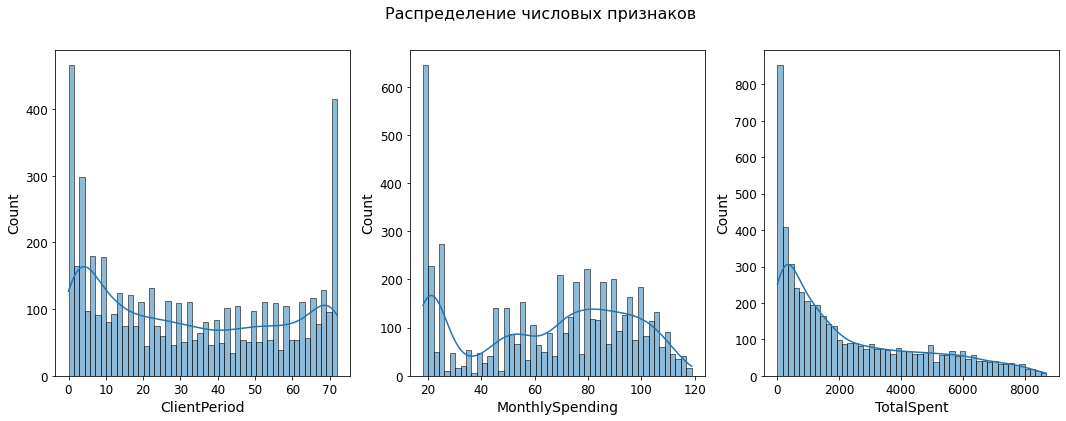

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
fig.suptitle("Распределение числовых признаков", fontsize=(16))
for idx, axis in enumerate(axes):
    sns.histplot(data=df[num_cols[idx]], kde=True, bins=50, ax=axis)

In [ ]:
# описательная статистика
df[num_cols].describe()

,ClientPeriod,MonthlySpending,TotalSpent
count,5282.000000,5282.000000,5273.000000
mean,32.397009,64.924754,2291.390461
std,24.550326,30.176464,2269.014233
min,0.000000,18.250000,18.800000
25%,9.000000,35.462500,401.100000
50%,29.000000,70.400000,1410.250000
75%,55.000000,90.050000,3807.350000
max,72.000000,118.750000,8684.800000


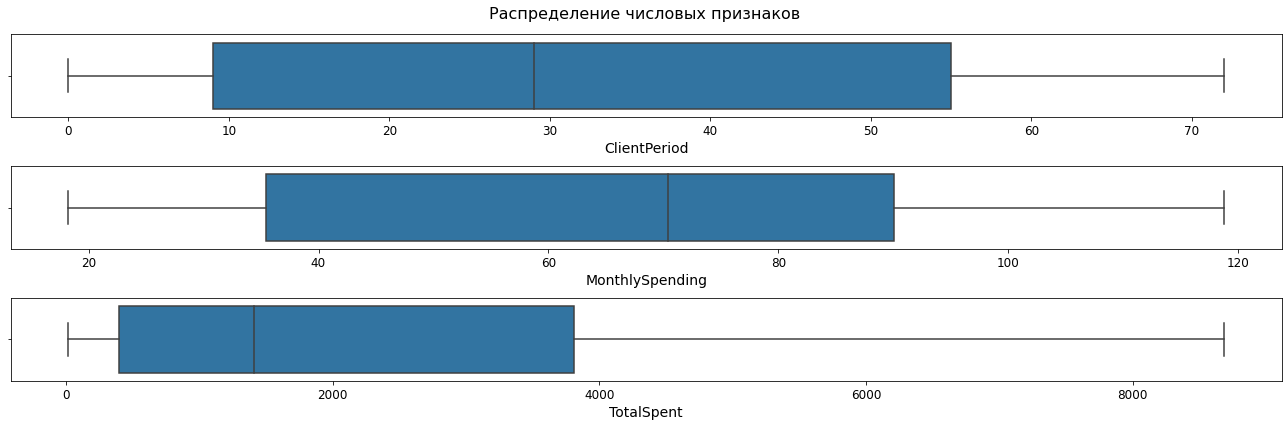

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(18, 6))
fig.suptitle("Распределение числовых признаков", fontsize=(16))
for idx, axis in enumerate(axes):
    sns.boxplot(x=df[num_cols[idx]], ax=axis)
plt.tight_layout()    
plt.show()    

(Дополнительно) Если вы нашли какие-то ошибки в данных или выбросы, то можете их убрать. Тут можно поэксперементировать с обработкой данных как угодно, но не за баллы.

#### Посмотрим на 10 самых наименьших и наибольших значений в числовых признаках

In [ ]:
for name_col in num_cols:
    print(f'Признак: {name_col}:')
    print(df.nsmallest(10, name_col)[name_col].to_list())
    print(df.nlargest(10, name_col)[name_col].to_list(), '\n')

Признак: ClientPeriod:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[72, 72, 72, 72, 72, 72, 72, 72, 72, 72] 

Признак: MonthlySpending:
[18.25, 18.4, 18.7, 18.7, 18.8, 18.8, 18.8, 18.8, 18.85, 18.85]
[118.75, 118.65, 118.6, 118.6, 118.35, 118.2, 117.8, 117.6, 117.5, 117.45] 

Признак: TotalSpent:
[18.8, 18.9, 19.05, 19.1, 19.1, 19.1, 19.15, 19.2, 19.2, 19.2]
[8684.8, 8672.45, 8670.1, 8594.4, 8564.75, 8547.15, 8543.25, 8529.5, 8477.7, 8477.6] 



Видим, что выбросы отсутствуют. Это было видно на боксплотах.

#### Посмотрим на категориальные признаки

In [ ]:
for name_col in cat_cols:
    print(f'Признак: "{name_col}", '
          f'уникальных: {df[name_col].nunique()} '
          f'{df[name_col].unique().tolist()}')

Признак: "Sex", уникальных: 2 ['Male', 'Female']
Признак: "IsSeniorCitizen", уникальных: 2 [0, 1]
Признак: "HasPartner", уникальных: 2 ['Yes', 'No']
Признак: "HasChild", уникальных: 2 ['Yes', 'No']
Признак: "HasPhoneService", уникальных: 2 ['Yes', 'No']
Признак: "HasMultiplePhoneNumbers", уникальных: 3 ['No', 'Yes', 'No phone service']
Признак: "HasInternetService", уникальных: 3 ['No', 'Fiber optic', 'DSL']
Признак: "HasOnlineSecurityService", уникальных: 3 ['No internet service', 'No', 'Yes']
Признак: "HasOnlineBackup", уникальных: 3 ['No internet service', 'No', 'Yes']
Признак: "HasDeviceProtection", уникальных: 3 ['No internet service', 'No', 'Yes']
Признак: "HasTechSupportAccess", уникальных: 3 ['No internet service', 'Yes', 'No']
Признак: "HasOnlineTV", уникальных: 3 ['No internet service', 'No', 'Yes']
Признак: "HasMovieSubscription", уникальных: 3 ['No internet service', 'No', 'Yes']
Признак: "HasContractPhone", уникальных: 3 ['One year', 'Two year', 'Month-to-month']
Признак: 

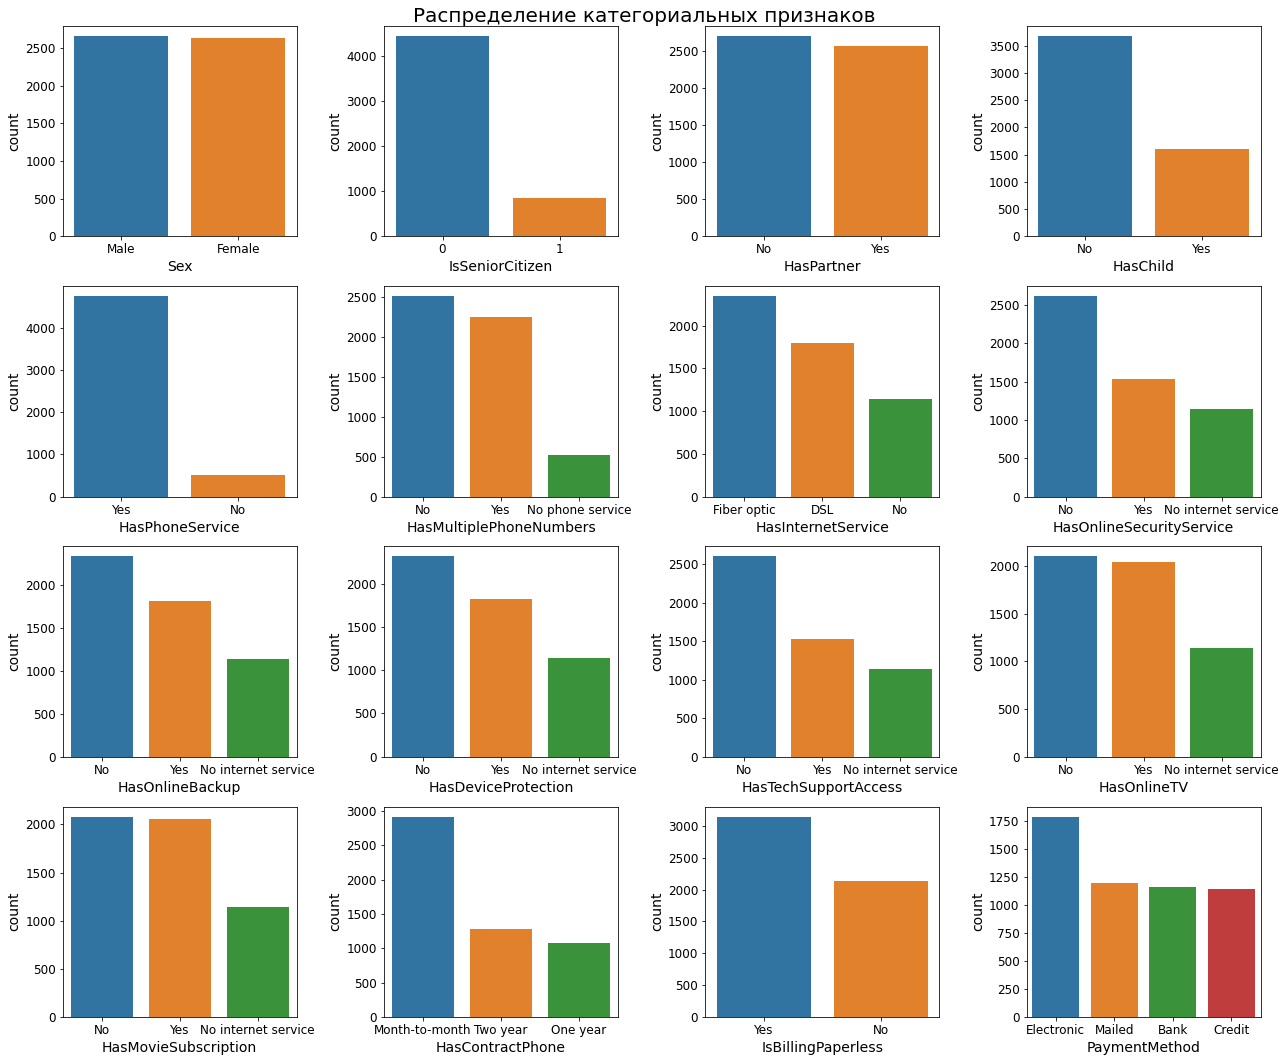

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(18, 15))
fig.suptitle("Распределение категориальных признаков", fontsize=20)
for row_ind, axis_row in enumerate(axes):
    for ax_ind, axis in enumerate(axis_row):
        index = ax_ind + 4 * row_ind
        counts = df[cat_cols[index]].value_counts()
        names = [name.split()[0] if index == 15 else name for name in counts.index]
        barplot = sns.barplot(x=names, y=counts.values, ax=axis)
        barplot.set_xlabel(cat_cols[index])
        barplot.set_ylabel('count')
plt.tight_layout()    
plt.show()        

### Посмотрим на распределение целевой переменной:

In [ ]:
df[target_col].value_counts()

0    3898
1    1384
Name: Churn, dtype: int64

In [ ]:
df[target_col].value_counts(normalize=True)

0    0.737978
1    0.262022
Name: Churn, dtype: float64

In [ ]:
imbalance = df[target_col].value_counts()[0] / df[target_col].value_counts()[1]
print(f'Дисбаланс классов = {round(imbalance,3)}. Объектов нулевого класса больше, чем первого.')

Дисбаланс классов = 2.816. Объектов нулевого класса больше, чем первого.


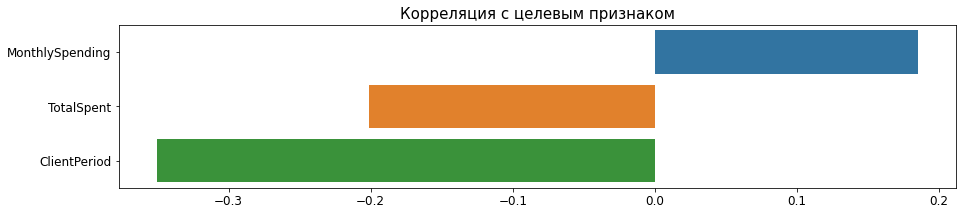

In [ ]:
corr_with_target = pd.DataFrame(df.drop(target_col, axis=1)[num_cols]
                                .corrwith(df[target_col])
                                .sort_values(ascending=False)).transpose()
plt.figure(figsize=(15, 3))
sns.barplot(data=corr_with_target, orient='h')
plt.title('Корреляция с целевым признаком')
plt.show()

In [ ]:
# объединим обучающую и тестовую выборки в один датафрейм для 
# детального исследования, но перед этим заполним поле отметки выборок.
test.TotalSpent = pd.to_numeric(test.TotalSpent, errors='coerce')
df['Learn'] = 1
test['Learn'] = 0
dataset = pd.concat([df.drop(target_col, axis=1), test])
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 1760
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              7043 non-null   int64  
 1   MonthlySpending           7043 non-null   float64
 2   TotalSpent                7032 non-null   float64
 3   Sex                       7043 non-null   object 
 4   IsSeniorCitizen           7043 non-null   int64  
 5   HasPartner                7043 non-null   object 
 6   HasChild                  7043 non-null   object 
 7   HasPhoneService           7043 non-null   object 
 8   HasMultiplePhoneNumbers   7043 non-null   object 
 9   HasInternetService        7043 non-null   object 
 10  HasOnlineSecurityService  7043 non-null   object 
 11  HasOnlineBackup           7043 non-null   object 
 12  HasDeviceProtection       7043 non-null   object 
 13  HasTechSupportAccess      7043 non-null   object 
 14  HasOnlin

**Проверим распределения вещественных признаков на трейне и тесте**

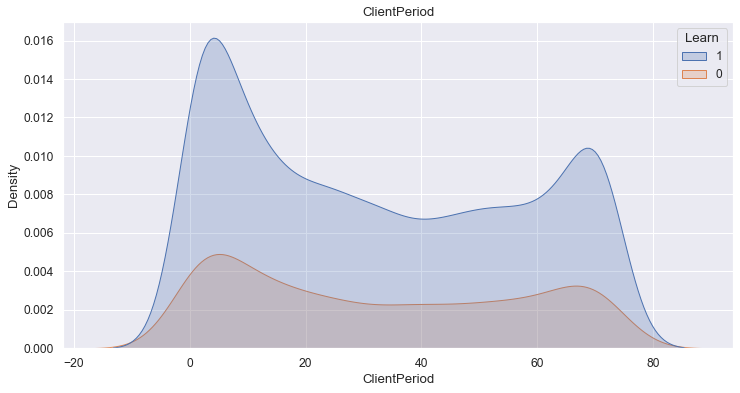

Но: Распределение нормальное. Признак "ClientPeriod": p-value = 0.0000
Отвергаем нулевую гипотезу? - ДА

Но: Распределения в группах равны. p-value = 0.3881
Отвергаем нулевую гипотезу? - НЕТ



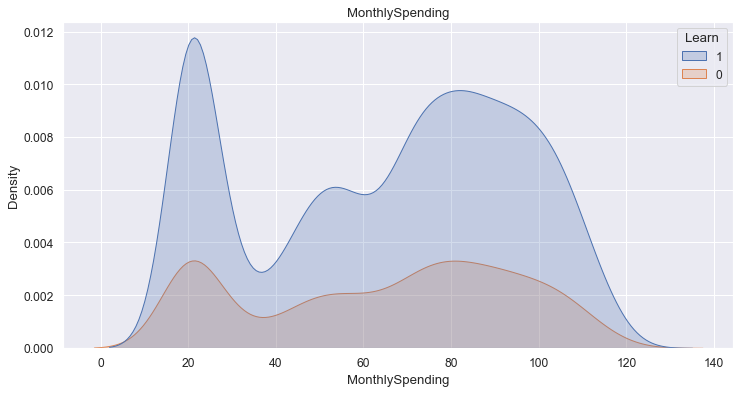

Но: Распределение нормальное. Признак "MonthlySpending": p-value = 0.0000
Отвергаем нулевую гипотезу? - ДА

Но: Распределения в группах равны. p-value = 0.1540
Отвергаем нулевую гипотезу? - НЕТ



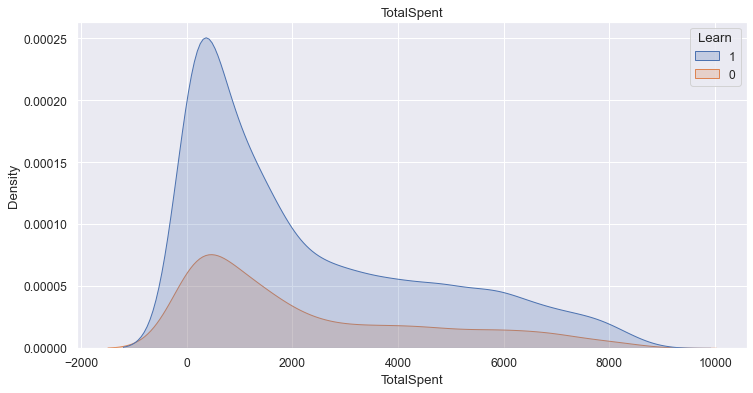

Но: Распределение нормальное. Признак "TotalSpent": p-value = 0.0000
Отвергаем нулевую гипотезу? - ДА

Но: Распределения в группах равны. p-value = 0.3005
Отвергаем нулевую гипотезу? - НЕТ



In [ ]:
def check_result(p_value, title='', feature=None):
    # задаем уровень значимости 5%
    alpha = 0.05
    if feature is not None:
        nf = f'Признак "{feature}": ' 
    else:
        nf = ''
    print(f'{title} {nf}p-value = {p_value:.4f}')
    # сравниваем p-значение с заданным уровнем статистической значимости
    print(f'Отвергаем нулевую гипотезу? - {["НЕТ", "ДА"][results.pvalue < alpha]}')
    print()


for col in num_cols:
    sns.set(font_scale=1.1)
    plt.figure(figsize=(12, 6))
    sns.kdeplot(data=dataset, x=col, shade=True, hue='Learn', hue_order=[1, 0])
    plt.title(col)
    plt.show()
    results = shapiro(dataset[col].dropna())
    check_result(results.pvalue, 'Но: Распределение нормальное.', col)
    results = mannwhitneyu(dataset[dataset.Learn == 1][col], dataset[dataset.Learn == 0][col])
    check_result(results.pvalue, 'Но: Распределения в группах равны.')

**Проверим распределения категориальных признаков на трейне и тесте**

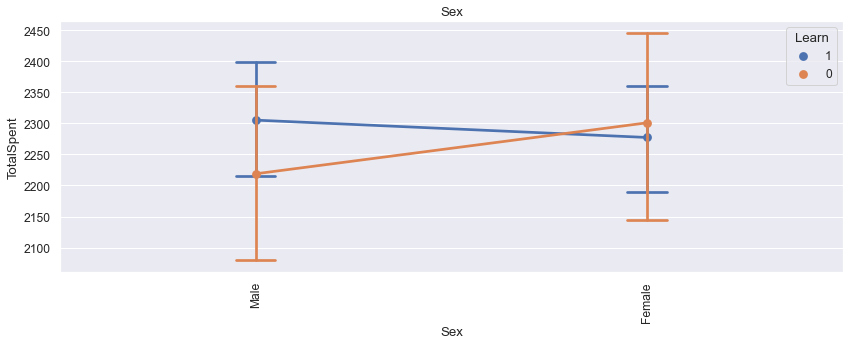

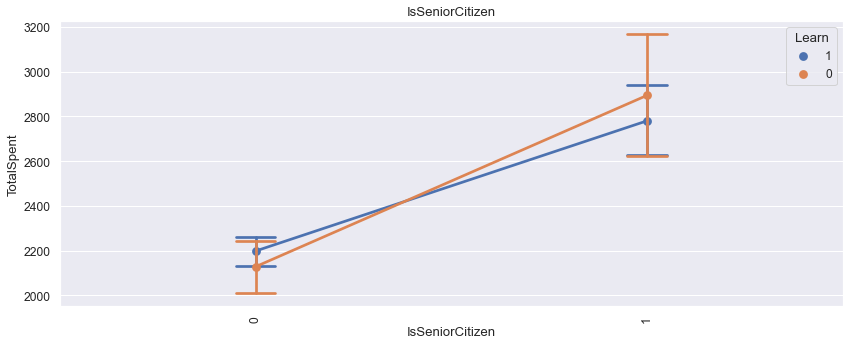

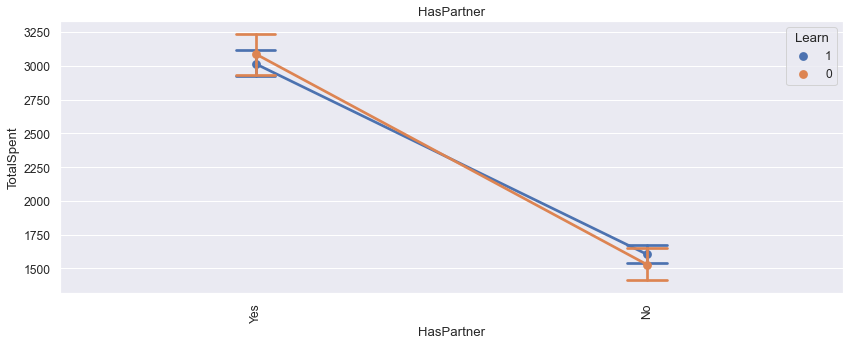

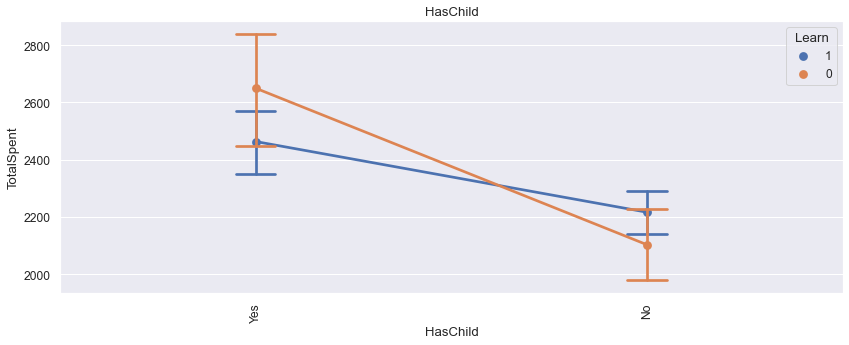

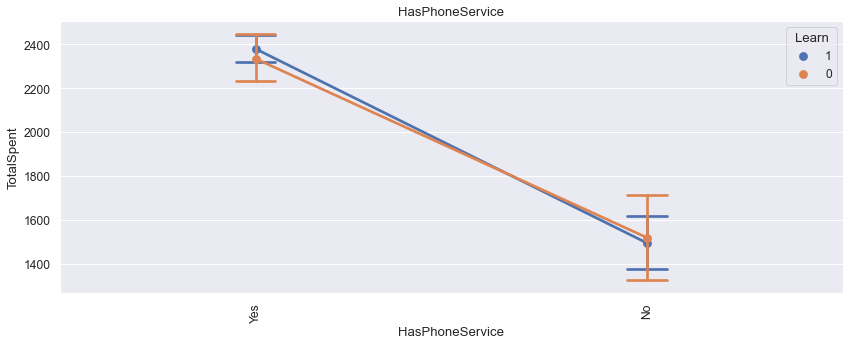

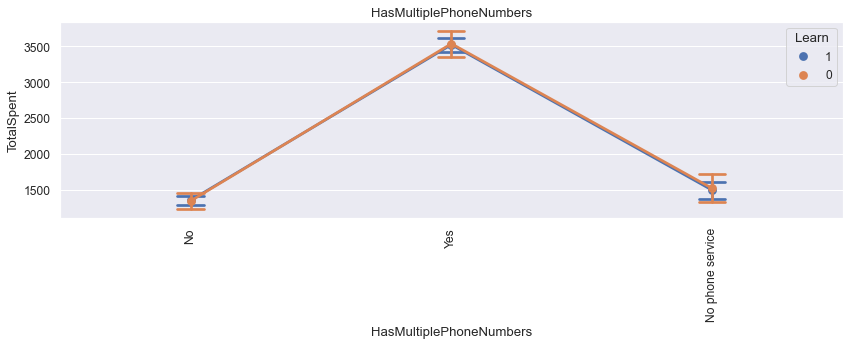

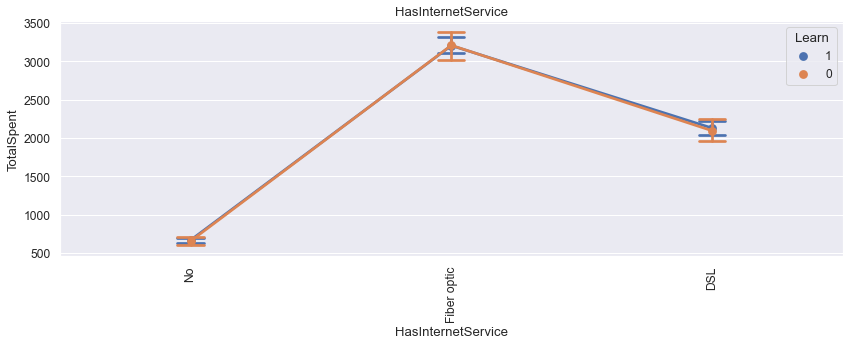

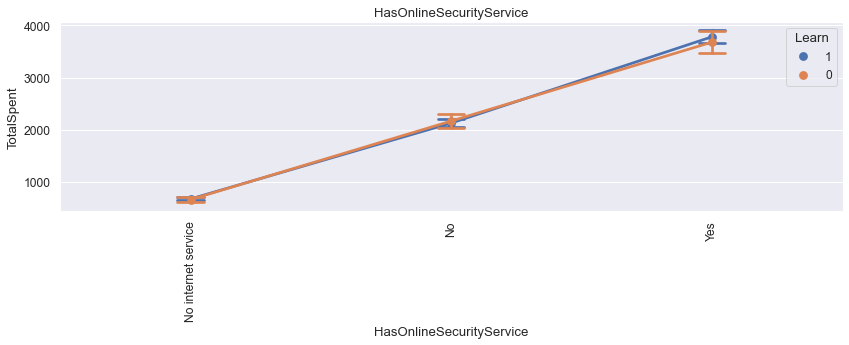

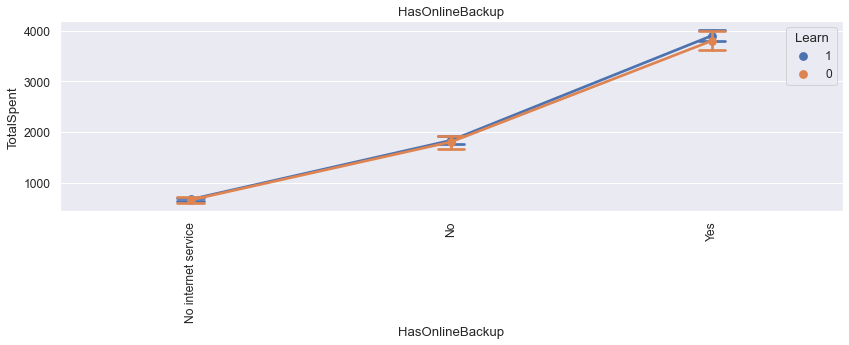

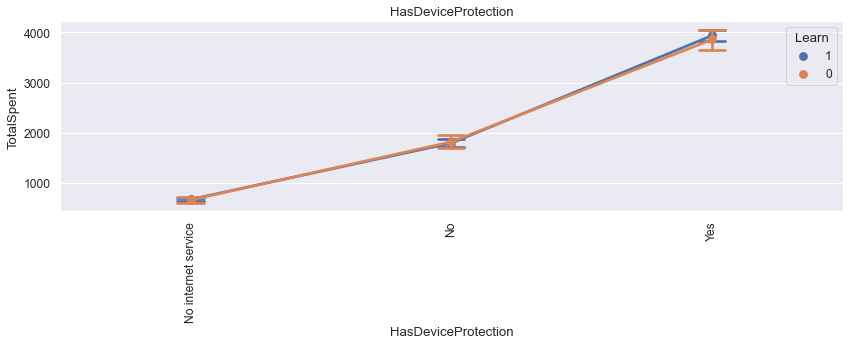

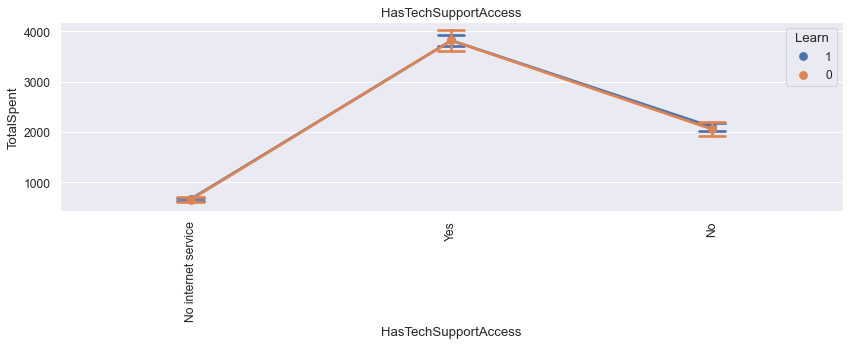

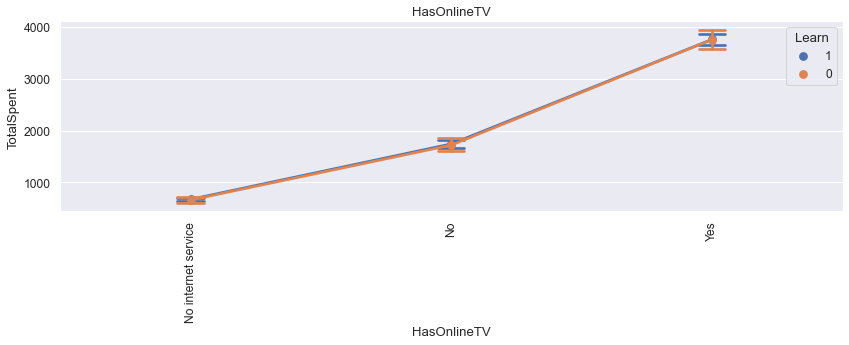

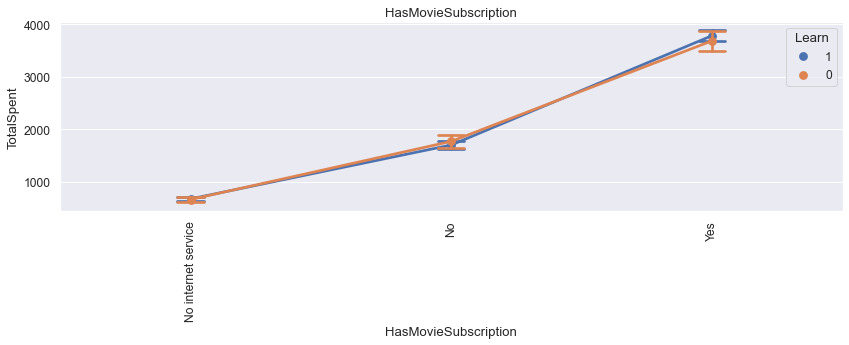

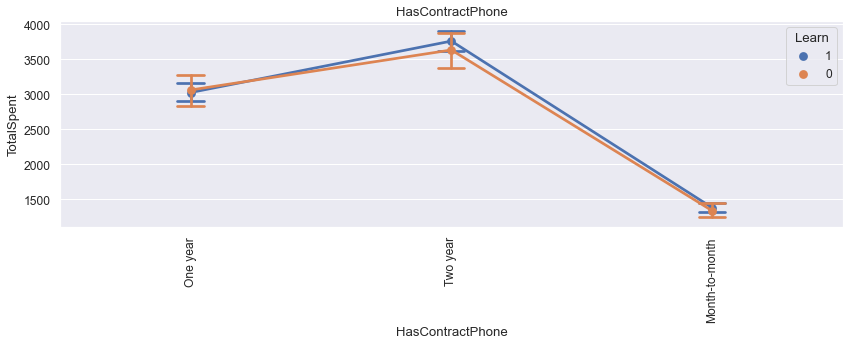

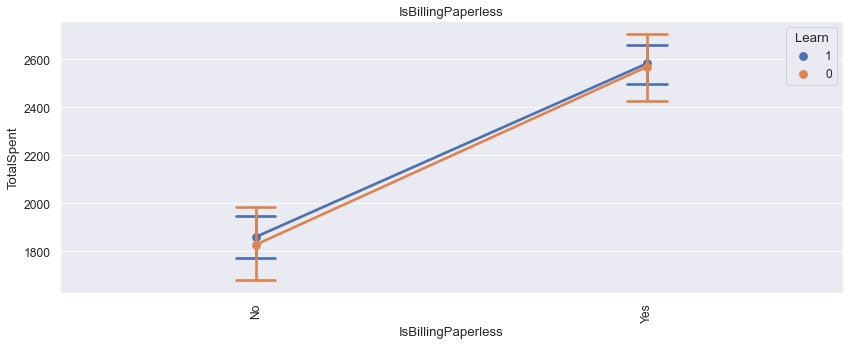

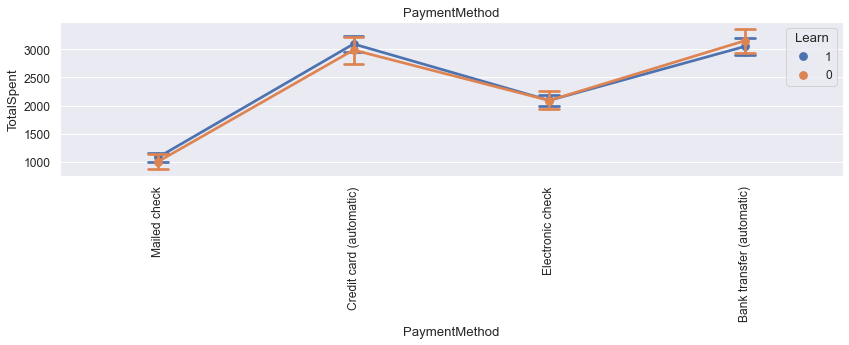

In [ ]:
num_feature = 'TotalSpent'
for col in cat_cols:
    sns.set(font_scale=1.1)
    fig, ax = plt.subplots(figsize=(12, 5))
    sns.pointplot(data=dataset, x=col, y=num_feature, capsize=.1, shade=True, hue='Learn', hue_order=[1, 0])
    plt.title(col)
    plt.setp(ax.get_xticklabels(), rotation=90)
    plt.tight_layout()
    plt.show()

**Различия в распределениях признаков на трейне и тесте не превышают уровня значимости, т.е. их можно считать одинаковыми, что важно для предсказаний по обучающей выборке**

## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

In [ ]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler

### Обработка данных

In [ ]:
class DataTransform:
    """Преобразование данных"""

    def __init__(self):
        self.mean_total_spent = None
        self.grp_total_spent = None
        self.grp_cols = ['HasPhoneService', 'HasInternetService',
                         'HasOnlineTV', 'HasContractPhone']
        self.sex_dict = {'Male': 0, 'Female': 1}
        self.no_yes_dict = {'No': 0, 'Yes': 1}
        self.num_cols = ['ClientPeriod', 'MonthlySpending', 'TotalSpent']
        self.bin_cols = ['Sex', 'HasPartner', 'HasChild', 'HasPhoneService',
                         'IsBillingPaperless']
        self.cat_cols = ['HasMultiplePhoneNumbers', 'HasInternetService',
                         'HasOnlineSecurityService', 'HasOnlineBackup',
                         'HasDeviceProtection', 'HasTechSupportAccess',
                         'HasOnlineTV', 'HasMovieSubscription',
                         'HasContractPhone', 'PaymentMethod']
        self.cat_features = []
        self.learn_columns = []
        self.data_comment = ''

    def fit(self, df_in):
        df = df_in.copy(deep=True)
        df.TotalSpent = pd.to_numeric(df.TotalSpent, errors='coerce')
        # среднее по всему ДФ
        self.mean_total_spent = np.mean(df.TotalSpent.mean() +
                                        df.TotalSpent.median())
        # среднее по группам
        grp = df.groupby(self.grp_cols).agg({'TotalSpent': ['mean', 'median']})
        grp['total_spent'] = grp.mean(axis=1)
        self.grp_total_spent = grp['total_spent']

    @staticmethod
    def remove_space(text):
        return ''.join(s for s in re.findall('\w+', text.title()))

    def fill_nan(self, row):
        idxs = tuple(row[col] for col in self.grp_cols)
        if idxs in self.grp_total_spent:
            return self.grp_total_spent.loc[idxs]
        return self.mean_total_spent

    def transform(self, df_in, dummy_cat_cols=True, fill_na_strategy=2):
        """
        Преобразование данных
        :param df_in: входной ДФ
        :param dummy_cat_cols: кодировать категориальные признаки
        :param fill_na_strategy: стратегия заполнения пропусков
                2 - среднее по категориям self.grp_cols по столбцу TotalSpent
                1 - среднее по всему столбцу TotalSpent
                0 - заполнение фиксированным значением = 1
        :return: преобразованных ДФ
        """
        df = df_in.copy(deep=True)

        # заполнение пропусков
        df.TotalSpent = pd.to_numeric(df.TotalSpent, errors='coerce')
        isna_index = df[df.TotalSpent.isna()].index
        if fill_na_strategy == 2:
            if self.grp_total_spent is not None:
                df.loc[isna_index, 'TotalSpent'] = df.loc[isna_index].apply(
                    self.fill_nan, axis=1)
            self.data_comment = 'grp_total_spent'
        elif fill_na_strategy == 1:
            df.TotalSpent.fillna(self.mean_total_spent)
            self.data_comment = 'mean_total_spent'
        else:
            value_ = 1
            df.TotalSpent.fillna(value_)
            self.data_comment = f'total_spent_value={value_}'
        # print(df.loc[isna_index, 'TotalSpent'])

        # удаление пробелов в значениях полей, чтобы колонки были без пробелов
        for col in self.cat_cols:
            df[col] = df[col].map(self.remove_space)

        if dummy_cat_cols:
            # кодировка бинарных признаков
            df['Sex'] = df['Sex'].map(self.sex_dict).astype(int)
            for col in self.bin_cols[1:]:
                df[col] = df[col].map(self.no_yes_dict).astype(int)
            # кодировка категорийных признаков
            df = pd.concat((df[self.num_cols + self.bin_cols],
                            pd.get_dummies(df[self.cat_cols],
                                           drop_first=True)),
                           axis=1)

        elif 'Churn' in df.columns:
            df.drop('Churn', axis=1, inplace=True)

        self.cat_features = [col for col in df.columns if
                             col not in self.num_cols]
        self.learn_columns = [*df.columns]
        return df

    def fit_transform(self, df_in, dummy_cat_cols=True, fill_na_strategy=2):
        self.fit(df_in)
        return self.transform(df_in, dummy_cat_cols=dummy_cat_cols,
                              fill_na_strategy=fill_na_strategy)

In [ ]:
# снова прочитаем данные и обработаем их
train = pd.read_csv(file_train)
target = train.Churn
test = pd.read_csv(file_test)

data = DataTransform()
train = data.fit_transform(train)
test = data.transform(test)

In [ ]:
train

,ClientPeriod,MonthlySpending,TotalSpent,Sex,HasPartner,HasChild,HasPhoneService,IsBillingPaperless,HasMultiplePhoneNumbers_NoPhoneService,HasMultiplePhoneNumbers_Yes,HasInternetService_FiberOptic,HasInternetService_No,HasOnlineSecurityService_NoInternetService,HasOnlineSecurityService_Yes,HasOnlineBackup_NoInternetService,HasOnlineBackup_Yes,HasDeviceProtection_NoInternetService,HasDeviceProtection_Yes,HasTechSupportAccess_NoInternetService,HasTechSupportAccess_Yes,HasOnlineTV_NoInternetService,HasOnlineTV_Yes,HasMovieSubscription_NoInternetService,HasMovieSubscription_Yes,HasContractPhone_OneYear,HasContractPhone_TwoYear,PaymentMethod_CreditCardAutomatic,PaymentMethod_ElectronicCheck,PaymentMethod_MailedCheck
0,55,19.50,1026.35,0,1,1,1,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1
1,72,25.85,1872.20,0,1,0,1,0,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,0
2,1,75.90,75.90,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,32,79.30,2570.00,1,1,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,60,115.25,6758.45,1,1,1,1,0,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5277,3,30.40,82.15,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
5278,50,44.45,2188.45,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0
5279,1,55.05,55.05,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1
5280,29,76.00,2215.25,1,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


#### Посмотрим на корреляцию признаков просле преобразования данных

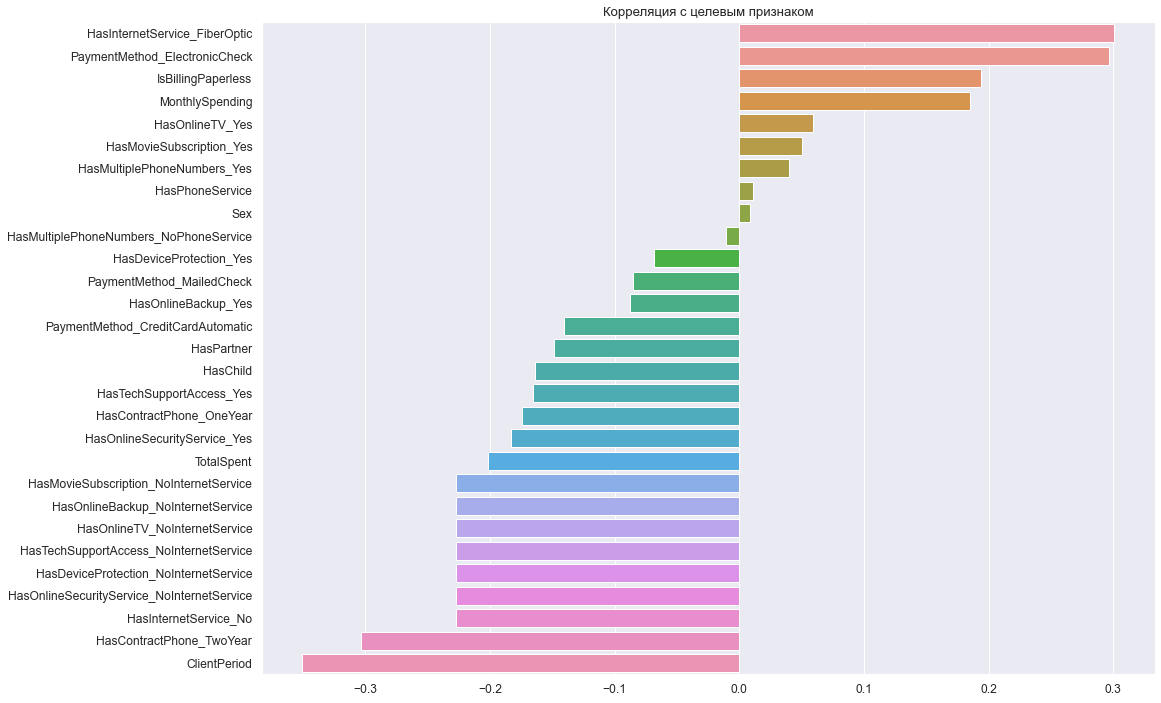

In [ ]:
df = pd.DataFrame(train.corrwith(target).sort_values(ascending=False)).transpose()
plt.figure(figsize=(16, 12))
sns.barplot(data=df, orient='h')
plt.title('Корреляция с целевым признаком')
plt.show()
df = df.transpose()
df.columns = ['value']

In [ ]:
# Обучение модели логистической регресии
X_train, X_valid, y_train, y_valid = train_test_split(train, target, test_size=.2, random_state=SEED)
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_valid[num_cols] = scaler.transform(X_valid[num_cols])
test[num_cols] = scaler.transform(test[num_cols])

logcv = LogisticRegressionCV(Cs=np.logspace(-2, 2.5, 30), random_state=SEED, scoring='roc_auc')

In [ ]:
logcv.fit(X_train, y_train)

LogisticRegressionCV(Cs=array([1.00000000e-02, 1.42946134e-02, 2.04335972e-02, 2.92090372e-02,
       4.17531894e-02, 5.96845700e-02, 8.53167852e-02, 1.21957046e-01,
       1.74332882e-01, 2.49202115e-01, 3.56224789e-01, 5.09209564e-01,
       7.27895384e-01, 1.04049831e+00, 1.48735211e+00, 2.12611233e+00,
       3.03919538e+00, 4.34441230e+00, 6.21016942e+00, 8.87719709e+00,
       1.26896100e+01, 1.81393069e+01, 2.59294380e+01, 3.70651291e+01,
       5.29831691e+01, 7.57373918e+01, 1.08263673e+02, 1.54758735e+02,
       2.21221629e+02, 3.16227766e+02]),
                     random_state=2022, scoring='roc_auc')

In [ ]:
# предсказание
best_C = logcv.C_[0]
y_train_pred = logcv.predict_proba(X_train)[:, 1]
y_valid_pred = logcv.predict_proba(X_valid)[:, 1]

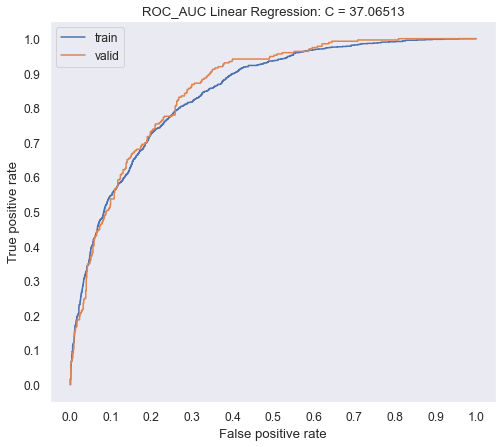

In [ ]:
# построение графика ROC_AUC
fig, ax = plt.subplots(figsize=(8, 7))
ax.plot(*roc_curve(y_train, y_train_pred)[:2], label='train')
ax.plot(*roc_curve(y_valid, y_valid_pred)[:2], label='valid')
ax.legend()
ax.set(xlabel='False positive rate', ylabel='True positive rate', 
       title=f'ROC_AUC Linear Regression: C = {round(best_C, 5)}')
ax.grid()
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_xticks(np.linspace(0, 1, 11));

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

In [ ]:
print(f'roc_auc_score = {roc_auc_score(y_valid, y_valid_pred)}, С = {best_C}')

roc_auc_score = 0.8560673473210942, С = 37.065129109221566


In [ ]:
# запись файла предсказаний на тестовых данных
submission = pd.read_csv(file_subm, index_col='Id')
submission['Churn'] = logcv.predict_proba(test)[:, 1]
submission.to_csv('logcv_submission.csv')

#### Пользователь Sas Pav: результат логистической регрессии на Kaggle = 0.84604, в рейтинге 1734 позиция.

## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные значения параметров количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

### 1. CatBoostClassifier cо стандартными параметрами.

In [ ]:
def plot_roc_auc(title=''):
    fig, ax = plt.subplots(figsize=(8, 7))
    ax.plot(*roc_curve(y_train, y_train_pred)[:2], label='train')
    ax.plot(*roc_curve(y_valid, y_valid_pred)[:2], label='valid')
    ax.legend()
    ax.set(xlabel='False positive rate', ylabel='True positive rate', 
           title=f'ROC_AUC catboost {title}')
    ax.grid()
    ax.set_yticks(np.linspace(0, 1, 11))
    ax.set_xticks(np.linspace(0, 1, 11));

In [ ]:
from catboost import CatBoostClassifier


train_df = pd.read_csv(file_train)
target = train_df.Churn
test_df = pd.read_csv(file_test)

data = DataTransform()
train = data.fit_transform(train_df, dummy_cat_cols=False)
test = data.transform(test_df, dummy_cat_cols=False)

X_train, X_valid, y_train, y_valid = train_test_split(train, target, test_size=0.2, random_state=SEED)

In [ ]:
cat_default = CatBoostClassifier(cat_features=data.cat_features,
                                 eval_metric='AUC:hints=skip_train~false')
cat_default.fit(X_train, y_train, verbose=False)
y_train_pred = cat_default.predict_proba(X_train)[:, 1]
y_valid_pred = cat_default.predict_proba(X_valid)[:, 1]

In [ ]:
print(f'roc_auc_score = {roc_auc_score(y_valid, y_valid_pred)}')

roc_auc_score = 0.8631111839640315


#### Результат CatBoostClassifier cо стандартными параметрами получился чуть лучше настроенной логистической регресии.

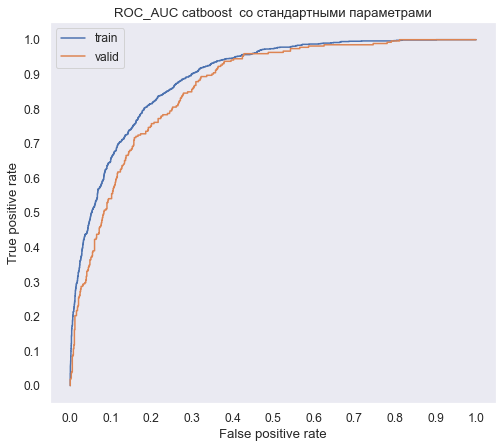

In [ ]:
plot_roc_auc(title=' cо стандартными параметрами')

### 2. Подбор гиперпараметров CatBoostClassifier.

In [ ]:
params = {
    'n_estimators': range(100, 701, 50),
    'learning_rate': [.005, .01, .025, .05, .1],
}
na_strategy = 1
data = DataTransform()
train = data.fit_transform(train_df, dummy_cat_cols=False,
                           fill_na_strategy=na_strategy)
test = data.transform(test_df, dummy_cat_cols=False,
                      fill_na_strategy=na_strategy)

In [ ]:
skf = StratifiedKFold(n_splits=6, random_state=SEED, shuffle=True)

cat_model = CatBoostClassifier(random_state=SEED, silent=True,
                               cat_features=data.cat_features,
                               auto_class_weights='Balanced',
                               eval_metric='AUC:hints=skip_train~false')

In [ ]:
cat_model.grid_search(params, train, target, cv=skf, stratified=True, refit=True, plot=True)
cat_model.fit(train, target, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.8210457355
bestIteration = 65

0:	loss: 0.8210457	best: 0.8210457 (0)	total: 2.82s	remaining: 3m

bestTest = 0.8277248199
bestIteration = 97

1:	loss: 0.8277248	best: 0.8277248 (1)	total: 5.06s	remaining: 2m 39s

bestTest = 0.8358100273
bestIteration = 90

2:	loss: 0.8358100	best: 0.8358100 (2)	total: 8.04s	remaining: 2m 46s

bestTest = 0.8370974516
bestIteration = 98

3:	loss: 0.8370975	best: 0.8370975 (3)	total: 10.6s	remaining: 2m 42s

bestTest = 0.8422014956
bestIteration = 99

4:	loss: 0.8422015	best: 0.8422015 (4)	total: 12.8s	remaining: 2m 33s

bestTest = 0.8261726062
bestIteration = 149

5:	loss: 0.8261726	best: 0.8422015 (4)	total: 14.9s	remaining: 2m 26s

bestTest = 0.8324773331
bestIteration = 149

6:	loss: 0.8324773	best: 0.8422015 (4)	total: 16.8s	remaining: 2m 19s

bestTest = 0.8383483533
bestIteration = 147

7:	loss: 0.8383484	best: 0.8422015 (4)	total: 18.5s	remaining: 2m 12s

bestTest = 0.8389920654
bestIteration = 142

8:	loss: 0.8389921	best: 0.8422015 

roc_auc_score = 0.8983795428999626


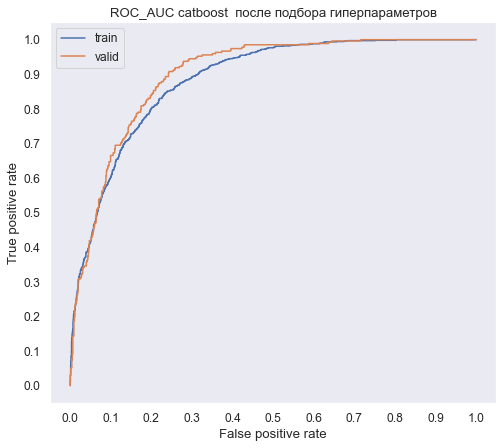

In [ ]:
y_train_pred = cat_model.predict_proba(X_train)[:, 1]
y_valid_pred = cat_model.predict_proba(X_valid)[:, 1]
print(f'roc_auc_score = {roc_auc_score(y_valid, y_valid_pred)}')
plot_roc_auc(title=' после подбора гиперпараметров')

Подбор гиперпараметров улучшил roc_auc более чем на 3%.

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

In [ ]:
model_params = cat_model.get_params()
model_params.pop('cat_features')
model_params.pop('silent')
print('Параметры модели:')
model_params

Параметры модели:


{'auto_class_weights': 'Balanced',
 'eval_metric': 'AUC:hints=skip_train~false',
 'random_state': 2022,
 'iterations': 300,
 'learning_rate': 0.05}

# Предсказания

In [ ]:
best_model = cat_model

In [ ]:
submission = pd.read_csv(file_subm, index_col='Id')
submission['Churn'] = best_model.predict_proba(test)[:, 1]
submission.to_csv('catcv_submission.csv')

#### Пользователь Sas Pav: результат CatBoostClassifier на Kaggle = 0.85196, в рейтинге 790 позиция.

#### Дальнейший подбор гиперпараметров по сетке:

In [ ]:
f_params = {
    'n_estimators': range(280, 381, 10),
    'max_depth': range(2, 7),
    'learning_rate': [.01, .025, .05, 0.1],
    'min_data_in_leaf': range(1, 5, 1),
    'subsample': np.linspace(.5, 1., 6),
    'l2_leaf_reg': np.linspace(3., 4., 11),
    'random_strength': np.linspace(1.2, 1.3, 11),
    'grow_policy': ['Lossguide'],
}

In [ ]:
new_model = CatBoostClassifier(random_state=SEED, silent=True,
                               cat_features=data.cat_features,
                               auto_class_weights='Balanced',
                               eval_metric='AUC:hints=skip_train~false')

In [ ]:
# несколько часов обучение
# new_model.grid_search(params, train, target, cv=skf, stratified=True, refit=True, plot=True)
# new_model.fit(train, target, verbose=False)

#### Получены такие результаты:

In [ ]:
best_params = {'depth': 4, 
               'iterations': 370,
               'min_data_in_leaf': 2,
               'subsample': 0.7, 
               'random_strength': 1.25, 
               'l2_leaf_reg': 3.2,
               'grow_policy': 'Lossguide'}

new_model = CatBoostClassifier(random_state=SEED, silent=True,
                               cat_features=data.cat_features,
                               auto_class_weights='Balanced',
                               eval_metric='AUC:hints=skip_train~false',
                               **best_params
                               )

new_model.fit(train, target, verbose=False)

In [ ]:
submission = pd.read_csv(file_subm, index_col='Id')
submission['Churn'] = new_model.predict_proba(test)[:, 1]
submission.to_csv('cat_best_submission.csv')

#### Пользователь Sas Pav: результат CatBoostClassifier на Kaggle = 0.85457, в рейтинге 82 позиция. 
#### На момент проверки задания рейтинг Sas Pav (профиль https://www.kaggle.com/saspav) может быть выше, т.к. опыты продолжаются...

# Kaggle (5 баллов)

Как выставить баллы:

1) 1 >= roc auc > 0.84 это 5 баллов

2) 0.84 >= roc auc > 0.7 это 3 балла

3) 0.7 >= roc auc > 0.6 это 1 балл

4) 0.6 >= roc auc это 0 баллов


Для выполнения задания необходимо выполнить следующие шаги.
* Зарегистрироваться на платформе [kaggle.com](kaggle.com). Процесс выставления оценок будет проходить при подведении итогового рейтинга. Пожалуйста, укажите во вкладке Team -> Team name свои имя и фамилию в формате Имя_Фамилия (важно, чтобы имя и фамилия совпадали с данными на Stepik).
* Обучить модель, получить файл с ответами в формате .csv и сдать его в конкурс. Пробуйте и экспериментируйте. Обратите внимание, что вы можете выполнять до 20 попыток сдачи на kaggle в день.
* После окончания соревнования отправить в итоговый ноутбук с решением на степик. 
* После дедлайна проверьте посылки других участников по критериям. Для этого надо зайти на степик, скачать их ноутбук и проверить скор в соревновании.